In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model


# Read The LME Spot Price Data

In [2]:
metal = 'LMSNDY'
price = pd.read_csv(metal+'.csv')
price['Index'] =  pd.to_datetime(price['Index'])

# Create return over several time horizon

In [3]:
price['return_1d'] = ((price[metal] / price[metal].shift(1)) -1)*100
price['return_3d'] = ((price[metal] / price[metal].shift(3)) -1)*100
price['return_5d'] = ((price[metal] / price[metal].shift(5)) -1)*100
price['return_7d'] = ((price[metal] / price[metal].shift(7)) -1)*100
price['return_10d'] = ((price[metal] / price[metal].shift(10)) -1)*100


# Read the Baidu Sentiment Score through analyzing each news title from Chinese new sources

In [4]:
sentiment = pd.read_csv('xi_sentiment.csv')
sentiment.drop(['url','title'],axis=1,inplace =True)

# Data Preprocessing

Since all data points in our file are unicode, we will define some functions to extract key information from the file and turn it into numerical value

In [5]:
def get_positive(string):
    return float(string.split(',')[0].split(',')[0][19:])
def get_confidence (string):
    return float(string.split(',')[1][16:])
def get_negative (string):
    return float(string.split(',')[2][19:])

In [6]:
sentiment['Pos'] = sentiment['Score'].apply(get_positive)
sentiment['Conf'] = sentiment['Score'].apply(get_confidence)
sentiment['Neg'] = sentiment['Score'].apply(get_negative)

# Create Indicator

Now we will create two indicators. 
1. First indicator will use the positive score - negative score, the larger the score, the more positive news will be. 
2. Second indicator will base on first indicator and times the confidence level in order to incorporate the factor related to confidence of the baidu api analysis into the indicator

In [7]:
sentiment['indi1'] = (sentiment['Pos'] -sentiment['Neg']) * 100
sentiment['indi2'] = (sentiment['Pos'] -sentiment['Neg']) * 100 * sentiment['Conf']

Now we will aggregate the indicator score of all news happened in a day into one final score

In [8]:
def create_indicator(df,indi):
    result =[]
    current_day = 0 
    current_score = 0
    num = 1 
    for day,score in zip(df['date'],df[indi]):
        if current_day == day:
            current_score += score
            num +=1
        else:
            result.append([current_day,current_score/num])
            current_day = day
            current_score = score
            num = 1
    result.append([current_day,current_score/num])
    final = pd.DataFrame(result[1:],columns=['Date','Score'])
    final['Date'] =  pd.to_datetime(final['Date'])
    return final


# Experiment relationship between backward return ratio and indicator 

Through our observation, we realize that most of the data we have are analyst reports which summarize events that have happended in the past (ranging from days to weeks) and analyse the impact of those events. Therefore, we can say that the most positive the score, the more positive the analyts in China feel about the market. 

Thus, the purpose of the following section is to experiment and check how the score might be related to financial market. We will check the following relationship:

#### 1. Relationship between today indicator score and the price changes for past few days( percentage changes between T and T - k)
The higher the score, more analyst are positive about the future, there will be more positive news that happend in the past and those news increase investors' risk appetite. Thus, we can assume that the price of today has incorporated those factors under efficient market theory. In other word, we should see a higher score correlated to a posivite price movement in the past

#### 2. Relationship between today indicator score and the price changes for next few days( percentage changes between T and T + k)
After checking the validity of the score, We will use the score to see whehter it has any predictive value in return.

#### 3. Relationship between today indicator score and the volatility changes for next few days
After checking the validity of the score, We will use the score to see whehter it has any predictive value in volatility.

Combine Indicator and price into one dataframe

In [9]:
indicator1 = create_indicator(sentiment,'indi1')
price_indicator = indicator1.merge(price, left_on='Date', right_on='Index',how='inner')
price_indicator.drop('Date',axis=1,inplace = True)
indicator2 = create_indicator(sentiment,'indi2')
price_indicator = indicator2.merge(price_indicator, left_on='Date', right_on='Index',how='inner')
price_indicator.drop('Index',axis=1,inplace = True)
price_indicator.rename(columns={'Score_x': 'Indi_1', 'Score_y': 'Indi_2'}, inplace=True)
price_indicator = price_indicator.reindex(index=price_indicator.index[::-1]).reset_index(drop = True)

In [10]:
def experiment_result(target,indicator,data):
    X = data[indicator].values
    X = np.reshape(X, (-1,1))
    data.plot.scatter(y =target,x=indicator,title = target +" vs "+indicator)
    print("Correlation is : " + str(data[indicator].corr(data[target])))
    target = data[target]
    model = linear_model.LinearRegression().fit(X,target)
    predicted = model.predict(X)
    plt.plot(data[indicator],predicted, 'r', label='fitted line')
    return

Correlation is : -0.014292616814656938


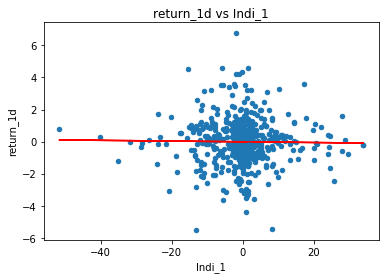

In [11]:
experiment_result('return_1d','Indi_1',price_indicator)

Correlation is : 0.03789133897304481


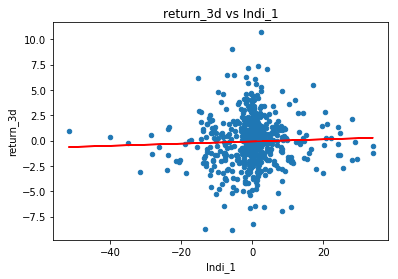

In [12]:
experiment_result('return_3d','Indi_1',price_indicator)

Correlation is : 0.045474580398091824


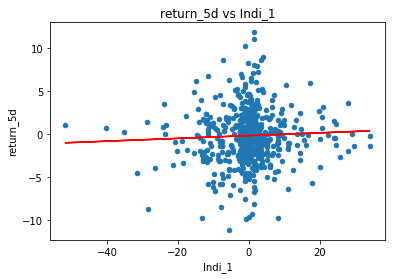

In [13]:
experiment_result('return_5d','Indi_1',price_indicator)

Correlation is : 0.058187314547048515


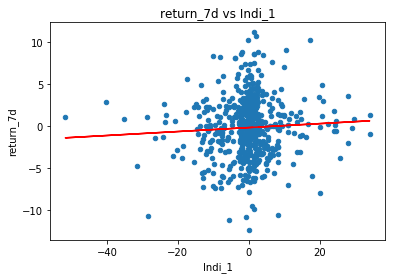

In [14]:
experiment_result('return_7d','Indi_1',price_indicator)

Correlation is : 0.03221813309990308


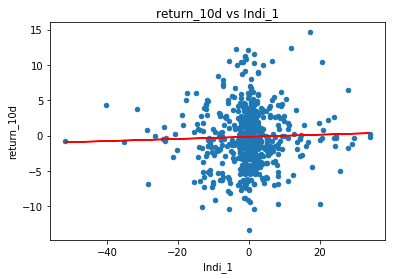

In [15]:
experiment_result('return_10d','Indi_1',price_indicator)

Correlation is : 0.001126591400039056


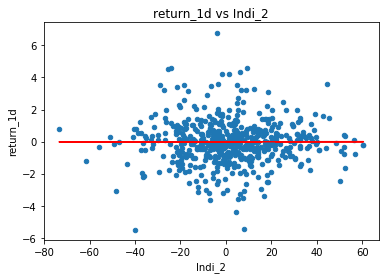

In [16]:
experiment_result('return_1d','Indi_2',price_indicator)

Correlation is : 0.04960887940054882


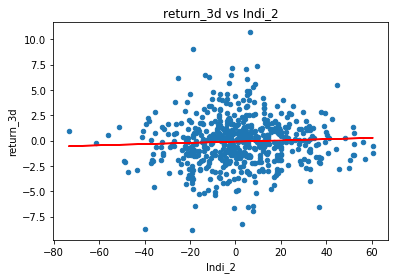

In [17]:
experiment_result('return_3d','Indi_2',price_indicator)

Correlation is : 0.040731609346983326


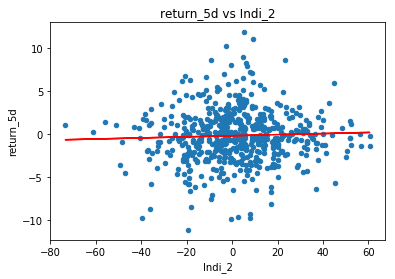

In [18]:
experiment_result('return_5d','Indi_2',price_indicator)

Correlation is : 0.03322833104591842


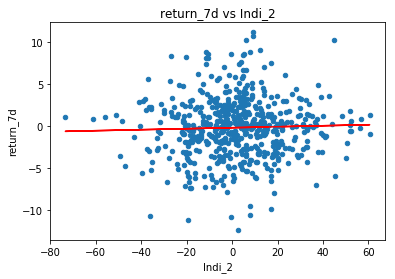

In [19]:
experiment_result('return_7d','Indi_2',price_indicator)

Correlation is : 0.02547831864450476


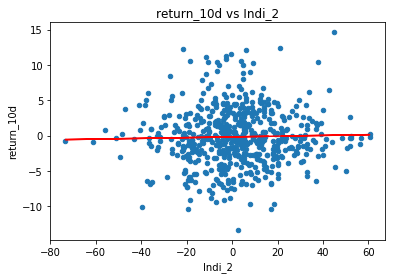

In [20]:
experiment_result('return_10d','Indi_2',price_indicator)

## Conclusion  1
From the experiment above, we are safe to assume that the sentiment score has incorporated the impact of past events in it instead of just being a random numerical value. Therefore, it makes sense for us to continue to improve the sentiment score as well as use it to do prediction for return

# Experiment relationship between forward return ratio and indicator 

In [21]:
price_forward = price.copy()

In [22]:
price_forward['return_1d'] = price_forward['return_1d'].shift(-1)
price_forward['return_3d'] = price_forward['return_3d'].shift(-3)
price_forward['return_5d'] = price_forward['return_5d'].shift(-5)
price_forward['return_7d'] = price_forward['return_7d'].shift(-7)
price_forward['return_10d'] = price_forward['return_10d'].shift(-10)


In [23]:
price_indicator_forward = indicator1.merge(price_forward, left_on='Date', right_on='Index',how='inner')
price_indicator_forward.drop('Date',axis=1,inplace = True)
price_indicator_forward = indicator2.merge(price_indicator_forward, left_on='Date', right_on='Index',how='inner')
price_indicator_forward.drop('Index',axis=1,inplace = True)
price_indicator_forward.rename(columns={'Score_x': 'Indi_1', 'Score_y': 'Indi_2'}, inplace=True)
price_indicator_forward = price_indicator_forward.reindex(index=price_indicator_forward.index[::-1]).reset_index(drop = True)
price_indicator_forward = price_indicator_forward.dropna()

Correlation is : -0.015688601280306486


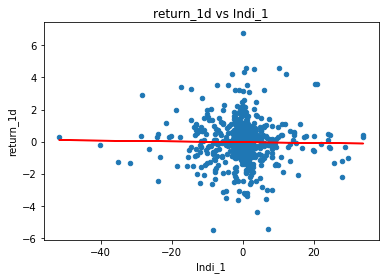

In [24]:
experiment_result('return_1d','Indi_1',price_indicator_forward)

Correlation is : -0.0660031760896201


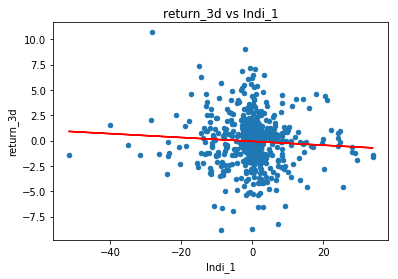

In [25]:
experiment_result('return_3d','Indi_1',price_indicator_forward)

Correlation is : -0.01994985683625156


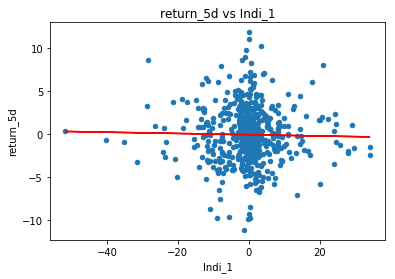

In [26]:
experiment_result('return_5d','Indi_1',price_indicator_forward)

Correlation is : -0.0024887306550360117


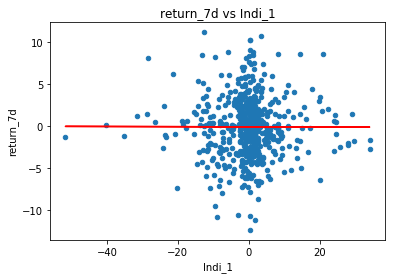

In [27]:
experiment_result('return_7d','Indi_1',price_indicator_forward)

Correlation is : -0.018393959273765987


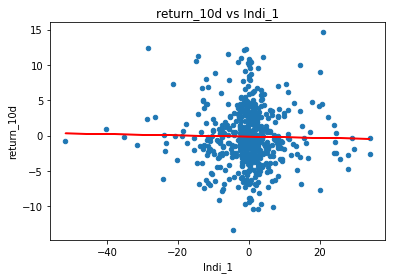

In [28]:
experiment_result('return_10d','Indi_1',price_indicator_forward)

Correlation is : -0.028951621913844885


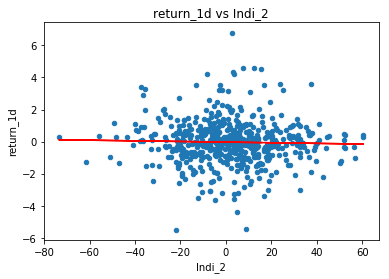

In [29]:
experiment_result('return_1d','Indi_2',price_indicator_forward)

Correlation is : -0.06562999629949279


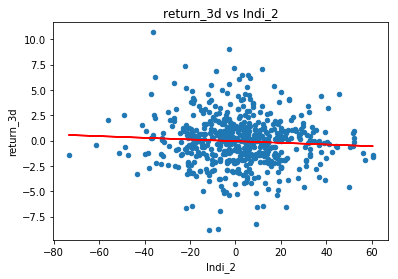

In [30]:
experiment_result('return_3d','Indi_2',price_indicator_forward)

Correlation is : -0.03334461887555653


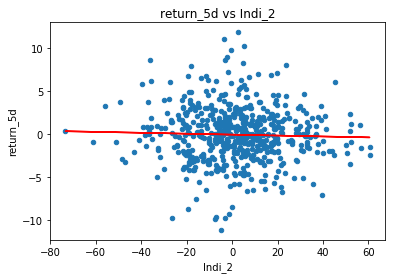

In [31]:
experiment_result('return_5d','Indi_2',price_indicator_forward)

Correlation is : -0.017656306363123084


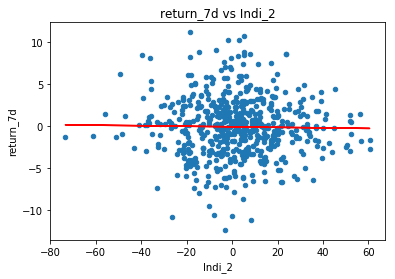

In [32]:
experiment_result('return_7d','Indi_2',price_indicator_forward)

Correlation is : -0.04400632018530248


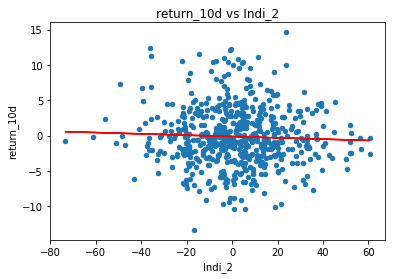

In [33]:
experiment_result('return_10d','Indi_2',price_indicator_forward)

## Conclusion  2
From the experiment above, we can tell sentiment score has zero correlation with future return. However, we can't conclude that it has zero predictive value in it. We will do other testing in next section 

# Experiment relationship between Volatility and indicator 

In [35]:
vol = price[[u'Index', u'LMSNDY', u'return_1d']].copy()

In [36]:
vol['Std'] = np.log(vol[u'return_1d'].rolling(10).std())

In [37]:
vol['std_1d'] = vol['Std'].shift(-1)
vol['std_3d'] = vol['Std'].shift(-3)
vol['std_5d'] = vol['Std'].shift(-5)
vol['std_7d'] = vol['Std'].shift(-7)
vol['std_10d'] = vol['Std'].shift(-10)

In [38]:
vol = vol.dropna()

In [39]:
vol_indicator = indicator1.merge(vol, left_on='Date', right_on='Index',how='inner')
vol_indicator.drop('Date',axis=1,inplace = True)
vol_indicator = indicator2.merge(vol_indicator, left_on='Date', right_on='Index',how='inner')
vol_indicator.drop('Index',axis=1,inplace = True)
vol_indicator.rename(columns={'Score_x': 'Indi_1', 'Score_y': 'Indi_2'}, inplace=True)

Correlation is : -0.1450647765047261


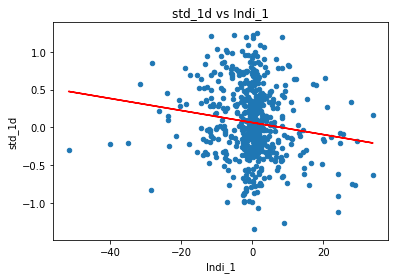

In [40]:
experiment_result('std_1d','Indi_1',vol_indicator)

Correlation is : -0.12253790322136926


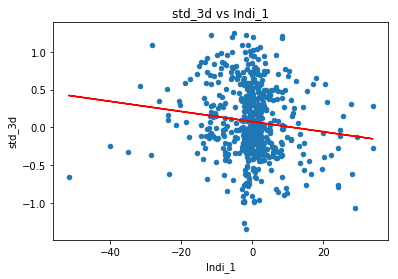

In [41]:
experiment_result('std_3d','Indi_1',vol_indicator)

Correlation is : -0.11618009264048493


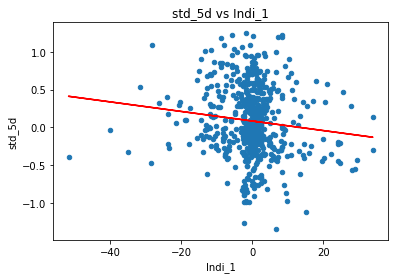

In [42]:
experiment_result('std_5d','Indi_1',vol_indicator)

Correlation is : -0.12473071429101121


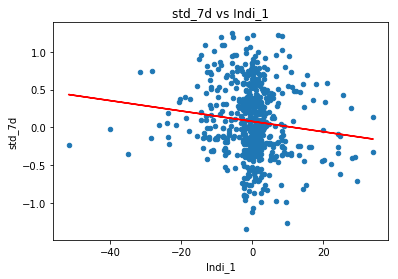

In [43]:
experiment_result('std_7d','Indi_1',vol_indicator)

Correlation is : -0.11293094630746041


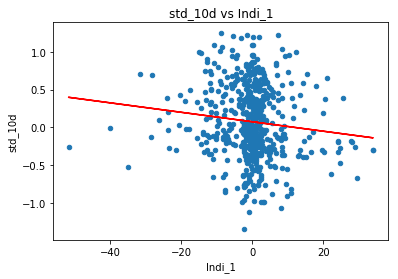

In [44]:
experiment_result('std_10d','Indi_1',vol_indicator)

Correlation is : -0.15683226283437668


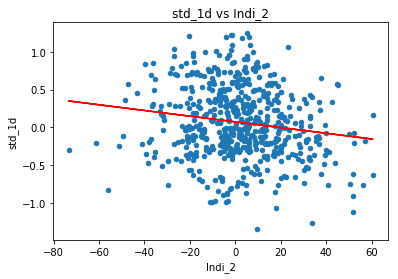

In [45]:
experiment_result('std_1d','Indi_2',vol_indicator)

Correlation is : -0.1410599582953793


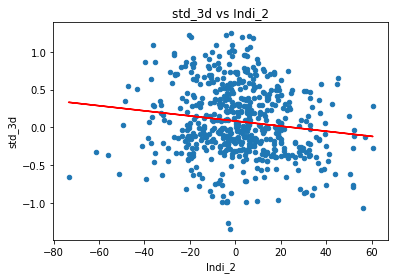

In [46]:
experiment_result('std_3d','Indi_2',vol_indicator)

Correlation is : -0.14187467671106432


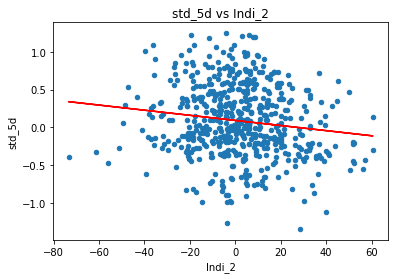

In [47]:
experiment_result('std_5d','Indi_2',vol_indicator)

Correlation is : -0.15078043774145333


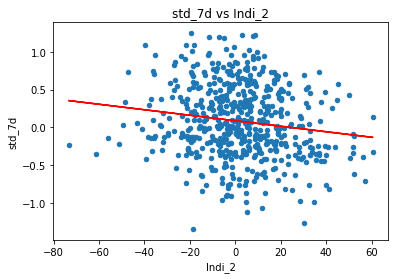

In [48]:
experiment_result('std_7d','Indi_2',vol_indicator)

Correlation is : -0.1297361173716863


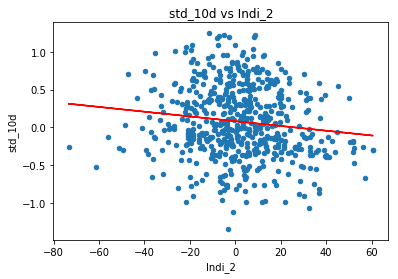

In [49]:
experiment_result('std_10d','Indi_2',vol_indicator)

## Conclusion  3
From the experiment above, we can tell sentiment score has certain negative correlation with future volatility. Therefore, it makes sense for us to continue to improve the sentiment score as well as use it to do prediction for volatility.


# Simple price prediction using indicator

In the following section, we will use the indicator to do simple prediction for different time horizon. The logis is as following:

1. If the indicator sign is bigger or equal to zero, we predict positive return for each time horizon
2. Else, negaive for each time horizon

Define a function to give positive sign to data point bigger than zero and negative sign to data point smaller than zero

In [50]:
def give_sign (data):
    if data>=0:
        return 1
    else:
        return -1

In [51]:
def prediction(result,data):
    indi_1 = data['Indi_1'].copy()
    indi_2 = data['Indi_2'].copy()
    sign_indi1 = indi_1.apply(give_sign)
    sign_indi2 = indi_2.apply(give_sign)
    
    sign_return = data[result].apply(give_sign)
    same_result_1= sign_return*sign_indi1
    reverse_result_1 = -sign_indi1*sign_return
    
    same_result_2= sign_return*sign_indi2
    reverse_result_2 = -sign_indi2*sign_return
    
    print('Number of positive in '+ result+ " : "+str(round(sign_return.value_counts()[1]/float(len(sign_return)),6)))
    print('Number of negative in '+ result+ " : "+str(round(sign_return.value_counts()[-1]/float(len(sign_return)),6)))
    print('Accuracy for following the same sign of Indicator 1 ' + result+ " : "+str(round(same_result_1.value_counts()[1]/float(len(sign_return)),6)))
    print('Accuracy for following the reverse sign of Indicator 1 '+ result+ " : "+str(round(reverse_result_1.value_counts()[1]/float(len(sign_return)),6)))
    print('Accuracy for following the same sign of Indicator 2 ' + result+ " : "+str(round(same_result_2.value_counts()[1]/float(len(sign_return)),6)))
    print('Accuracy for following the reverse sign of Indicator 2 '+ result+ " : "+str(round(reverse_result_2.value_counts()[1]/float(len(sign_return)),6)))

In [52]:
prediction('return_1d',price_indicator_forward)

Number of positive in return_1d : 0.479239
Number of negative in return_1d : 0.520761
Accuracy for following the same sign of Indicator 1 return_1d : 0.472318
Accuracy for following the reverse sign of Indicator 1 return_1d : 0.527682
Accuracy for following the same sign of Indicator 2 return_1d : 0.477509
Accuracy for following the reverse sign of Indicator 2 return_1d : 0.522491


In [53]:
prediction('return_3d',price_indicator_forward)

Number of positive in return_3d : 0.49654
Number of negative in return_3d : 0.50346
Accuracy for following the same sign of Indicator 1 return_3d : 0.468858
Accuracy for following the reverse sign of Indicator 1 return_3d : 0.531142
Accuracy for following the same sign of Indicator 2 return_3d : 0.477509
Accuracy for following the reverse sign of Indicator 2 return_3d : 0.522491


In [54]:
prediction('return_5d',price_indicator_forward)

Number of positive in return_5d : 0.486159
Number of negative in return_5d : 0.513841
Accuracy for following the same sign of Indicator 1 return_5d : 0.472318
Accuracy for following the reverse sign of Indicator 1 return_5d : 0.527682
Accuracy for following the same sign of Indicator 2 return_5d : 0.470588
Accuracy for following the reverse sign of Indicator 2 return_5d : 0.529412


In [55]:
prediction('return_7d',price_indicator_forward)

Number of positive in return_7d : 0.491349
Number of negative in return_7d : 0.508651
Accuracy for following the same sign of Indicator 1 return_7d : 0.470588
Accuracy for following the reverse sign of Indicator 1 return_7d : 0.529412
Accuracy for following the same sign of Indicator 2 return_7d : 0.475779
Accuracy for following the reverse sign of Indicator 2 return_7d : 0.524221


In [56]:
prediction('return_10d',price_indicator_forward)

Number of positive in return_10d : 0.432526
Number of negative in return_10d : 0.567474
Accuracy for following the same sign of Indicator 1 return_10d : 0.477509
Accuracy for following the reverse sign of Indicator 1 return_10d : 0.522491
Accuracy for following the same sign of Indicator 2 return_10d : 0.482699
Accuracy for following the reverse sign of Indicator 2 return_10d : 0.517301
